# CIFAR10 90% test accuracy
This notebook is a (hopefully cleaner) reimplementation of a [kaggle notebook](https://www.kaggle.com/code/kmldas/cifar10-resnet-90-accuracy-less-than-5-min).  
The first goal is to familiarize my self with more advanced architecture and training method than the baseline tutorial model.  
The second goal is to interpret the trained model.  

## Setup

### Imports

In [1]:
from collections.abc import Sequence

import torch
from torch import Tensor
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch.multiprocessing as mp
from torch.nn import CrossEntropyLoss
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.transforms import (
    Compose,
    ToTensor,
    Normalize,
    RandomCrop,
    RandomHorizontalFlip,
)

from models import ResNet9
from trainer import Trainer
from data_loaders import MyDataLoader as DL
from adversarial_attacks import ProjectedGradientDescent as PGD

# mp.set_start_method('spawn', force=True)

### Search for an accelerator

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Model definition

In [3]:
model = ResNet9(3, 10).cuda()
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Datasets, Transforms and Data loaders

### Transforms

In [4]:
CHANNELS_MEAN = (0.4914, 0.4822, 0.4465)
CHANNELS_STD = (0.2023, 0.1994, 0.2010)

training_transform = Compose([
    RandomCrop(32, padding=4, padding_mode="constant"),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(CHANNELS_MEAN, CHANNELS_STD, inplace=True),
])
attacker = PGD(10, 4/255, CrossEntropyLoss(), model, 50/255)

validation_transform = Compose([ToTensor(), Normalize(CHANNELS_MEAN, CHANNELS_STD)])

### Datasets

In [5]:
training_dataset = CIFAR10(root="./datasets/cifar10/", train=True, download=True, transform=training_transform)
validation_dataset = CIFAR10(root="./datasets/cifar10/", train=False, transform=validation_transform)

Files already downloaded and verified


### Datasets loaders

In [6]:
BATCH_SIZE = 400

training_dl = DL(training_dataset, BATCH_SIZE, shuffle=True, num_workers=3, device=device, pin_memory=True, attacker=attacker)
validation_dl = DL(validation_dataset, BATCH_SIZE * 2, num_workers=3, device=device, pin_memory=True, attacker=attacker)

### Dataset visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


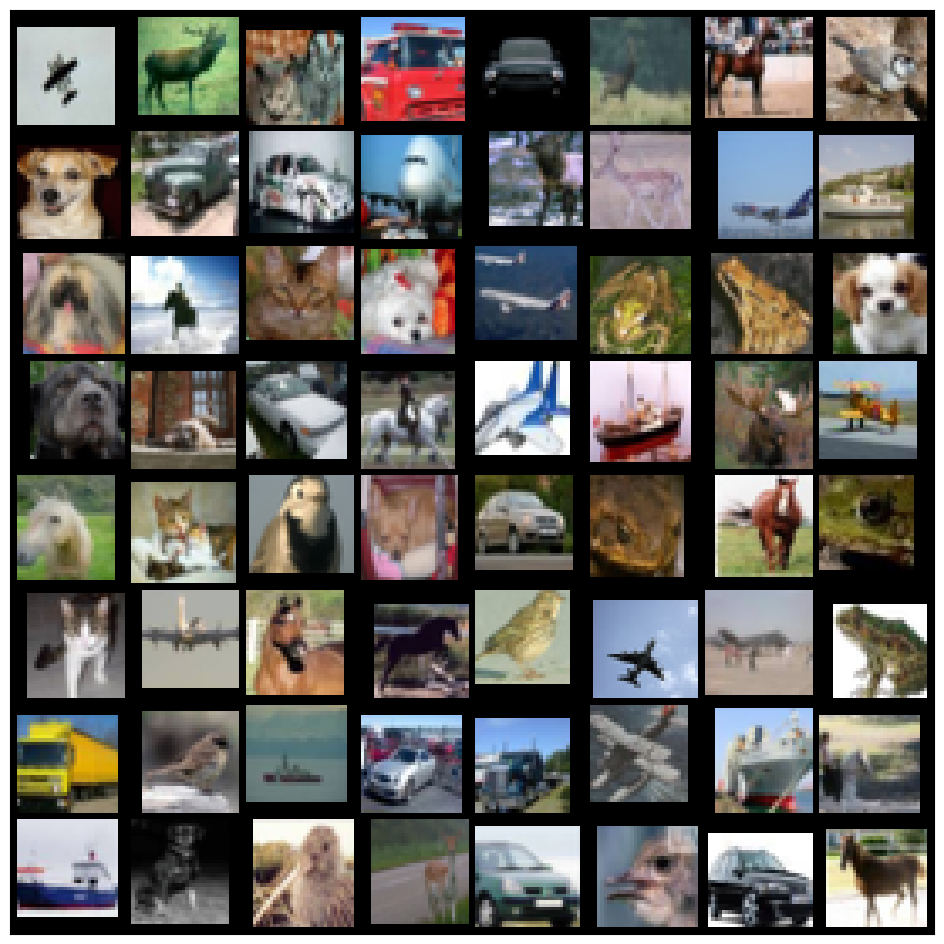

In [7]:
base_imgs, labels = next(iter(training_dl))
images, labels = base_imgs.cpu(), labels.cpu()
as_tensor = lambda stats: Tensor(stats).view(1, 3, 1, 1)
unormalize_imgs =  lambda imgs: imgs * as_tensor(CHANNELS_STD) + as_tensor(CHANNELS_MEAN)
images = unormalize_imgs(images)
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))

In [8]:
EPOCHS = 16
MAX_LR = 0.01
optimizer = Adam(model.parameters(), MAX_LR, weight_decay=1e-4)
lr_scheduler = OneCycleLR(optimizer, MAX_LR, epochs=EPOCHS, steps_per_epoch=len(training_dl))
trainer = Trainer(
    model,
    optimizer,
    lr_scheduler = lr_scheduler,
)

In [9]:
training_metrics = trainer.optimize_nn(
    epochs=EPOCHS,
    train_dl=training_dl,
    test_dl=validation_dl,
    plt_kwargs=dict(x="epoch", y=["train_loss", "train_accuracy", "test_loss", "test_accuracy"], height=600),
).set_index("epoch")

FigureWidget({
    'data': [{'hovertemplate': 'variable=train_loss<br>epoch=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'train_loss',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': 'train_loss',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'uid': '7d817064-ea6d-4710-8b76-b3e82a5ef4ce',
              'x': array([0]),
              'xaxis': 'x4',
              'y': array([2.34908077]),
              'yaxis': 'y4'},
             {'hovertemplate': 'variable=train_accuracy<br>epoch=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'train_accuracy',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': 'train_accuracy',
              'orientation': 'v',
   

In [10]:
! mkdir -p "models"
torch.save(model.state_dict(), "./models/" + model.name + ".pth")

In [11]:
training_metrics

,step,date,test_loss,test_accuracy,train_loss,train_accuracy,lr,betas,eps,weight_decay,...,foreach,capturable,differentiable,fused,initial_lr,max_lr,min_lr,max_momentum,base_momentum,params
epoch,,,,,,,,,,,,,,,,,,,,,
0,0,2025-06-03 10:35:59.597144,2.349901,0.10000,2.349081,0.10000,4.000000e-04,"(0.95, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,125,2025-06-03 10:38:02.586454,1.763908,0.36105,1.951849,0.29691,1.395099e-03,"(0.9396343851261465, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,250,2025-06-03 10:40:05.180746,1.804201,0.36880,1.733700,0.36268,3.967804e-03,"(0.9128353793731082, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,375,2025-06-03 10:42:07.943780,1.879769,0.34795,1.638976,0.40818,7.051407e-03,"(0.8807145096464123, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,500,2025-06-03 10:44:10.675539,1.869949,0.37610,1.581993,0.42851,9.367372e-03,"(0.8565898785460645, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
5,625,2025-06-03 10:46:13.338400,1.535598,0.46025,1.467060,0.47149,9.991492e-03,"(0.8500850760230118, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
6,750,2025-06-03 10:48:16.016454,1.459560,0.48060,1.378446,0.50463,9.715700e-03,"(0.8528430095009334, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
7,875,2025-06-03 10:50:18.722572,1.396125,0.51255,1.306402,0.53187,9.071305e-03,"(0.8592869859342811, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
8,1000,2025-06-03 10:52:21.401006,1.304257,0.53225,1.258357,0.55038,8.108677e-03,"(0.8689133096103789, 0.999)",1.000000e-08,0.0001,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
